<a href="https://colab.research.google.com/github/qkrwoghd04/ImageCaptionnng_Using_ViT/blob/master/practice/Vision_Transformer_Architecture_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ViT Architecture Practice

Distinguishing between a person **sleeping** and a person **falling down**


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.1.1 which is incompatible.


In [ ]:
# !pip install ops

## Initialization

In [71]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import keras as keras
from keras import ops

# 모델 파일 경로
model_path = r'/content/drive/MyDrive/Fall_vs_Sleep_ViTmodel.keras'

#hyperparameter
input_shape = (32,32,3)
batch_size = 16
epochs = 70
lr = 3e-6
gamma = 0.7
seed = 142
image_size = 224
patch_size = 64
num_classes = 2
weight_decay = 4e-5

In [44]:
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
# 이미지와 레이블을 저장할 리스트 초기화
x_train = []
y_train = []

# 클래스별로 폴더 경로 설정
classes = ['Fall', 'Sleep']
class_labels = {'Fall': 0, 'Sleep': 1}

base_path = r'/content/drive/MyDrive/image_dataset_splited/train'

for class_name in classes:
    class_dir = os.path.join(base_path, class_name)
    for img_name in os.listdir(class_dir):
        # 이미지 로드 및 리사이즈
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path, target_size=(input_shape))
        img_array = img_to_array(img)

        # 이미지와 레이블 리스트에 추가
        x_train.append(img_array)
        y_train.append(class_labels[class_name])

# 리스트를 NumPy 배열로 변환
x_train = np.array(x_train)
y_train = np.array(y_train)


# 데이터 차원 출력
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")


x_train: (320, 32, 32, 3), y_train: (320,)


In [45]:
# 이미지와 레이블을 저장할 리스트 초기화
x_val = []
y_val = []

# 클래스별로 폴더 경로 설정
classes = ['Fall', 'Sleep']
class_labels = {'Fall': 0, 'Sleep': 1}

base_path = r'/content/drive/MyDrive/image_dataset_splited/val'

for class_name in classes:
    class_dir = os.path.join(base_path, class_name)
    for img_name in os.listdir(class_dir):
        # 이미지 로드 및 리사이즈
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path, target_size=(input_shape))
        img_array = img_to_array(img)

        # 이미지와 레이블 리스트에 추가
        x_val.append(img_array)
        y_val.append(class_labels[class_name])

# 리스트를 NumPy 배열로 변환
x_val = np.array(x_val)
y_val = np.array(y_val)


# 데이터 차원 출력
print(f"x_val: {x_train.shape}, y_val: {y_train.shape}")


x_val: (320, 32, 32, 3), y_val: (320,)


In [46]:
x_test = []
y_test = []

# 클래스별로 폴더 경로 설정
classes = ['Fall', 'Sleep']
class_labels = {'Fall': 0, 'Sleep': 1}

base_path = '/content/drive/MyDrive/image_dataset_splited/test'

for class_name in classes:
    class_dir = os.path.join(base_path, class_name)
    for img_name in os.listdir(class_dir):
        # 이미지 로드 및 리사이즈
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path, target_size=(input_shape))
        img_array = img_to_array(img)

        # 이미지와 레이블 리스트에 추가
        x_test.append(img_array)
        y_test.append(class_labels[class_name])

# 리스트를 NumPy 배열로 변환
x_test = np.array(x_test)
y_test = np.array(y_test)


# 데이터 차원 출력
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")


x_test: (40, 32, 32, 3), y_test: (40,)


In [60]:
num_patches = (image_size//patch_size)**2

# D
projection_dim = 64
num_heads = 4

transformer_units = [
    projection_dim*2,
    projection_dim,
]

transformer_layers = 12
mlp_head_units = [2048, 1024]

In [61]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),

    ],
    name = 'data_augmentation',
)
data_augmentation.layers[0].adapt(x_train)

In [62]:
def mlp(x, hidden_units, dropout_rate):


  for units in hidden_units:
    x = layers.Dense(units,activation=tf.nn.gelu)(x) #GELU(Gaussian Error Linear Unit)
    x = layers.Dropout(dropout_rate)(x)
  return x

In [63]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

Image size: 224 X 224
Patch size: 64 X 64
Patches per image: 9
Elements per patch: 12288
Shape of patch: (1, 9, 12288)


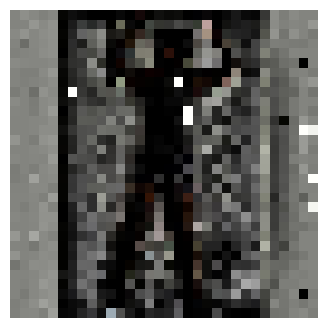

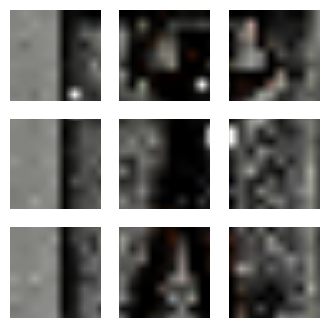

In [64]:
# @title
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
print(f"Shape of patch: {patches.shape}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

In [65]:
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super().__init__()
    self.num_patches = num_patches

    self.projection = layers.Dense(units=projection_dim)
    self.position_embedding = layers.Embedding(
        input_dim = num_patches, output_dim = projection_dim
    )

  def call(self, patch):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(patch) + self.position_embedding(positions)
    return encoded

In [73]:
def vit():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.4)
    # Classify outputs.
    logits = layers.Dense(1, activation='sigmoid')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [74]:
model = vit()
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ data_augmentation         │ (None, 224, 224, 3)    │              7 │ input_layer_10[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patches_11 (Patches)      │ (None, 9, 12288)       │              0 │ data_augmentation[1][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_encoder_6           │ (None, 9, 64)          │        787,072 │ patches_11[0][0]       │
│ (PatchEncoder)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_118   │ (None, 9, 64)          │            128 │ patch_encoder_6[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_56   │ (None, 9, 64)          │         66,368 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_112 (Add)             │ (None, 9, 64)          │              0 │ multi_head_attention_… │
│                           │                        │                │ patch_encoder_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_119   │ (None, 9, 64)          │            128 │ add_112[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_137 (Dense)         │ (None, 9, 128)         │          8,320 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_187 (Dropout)     │ (None, 9, 128)         │              0 │ dense_137[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_138 (Dense)         │ (None, 9, 64)          │          8,256 │ dropout_187[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_188 (Dropout)     │ (None, 9, 64)          │              0 │ dense_138[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_113 (Add)             │ (None, 9, 64)          │              0 │ dropout_188[0][0],     │
│                           │                        │                │ add_112[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_120   │ (None, 9, 64)          │            128 │ add_113[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_57   │ (None, 9, 64)          │         66,368 │ layer_normalization_1… │
│ (MultiHeadAttention) 

 Total params: 5,066,504 (19.33 MB)

 Trainable params: 5,066,497 (19.33 MB)

 Non-trainable params: 7 (32.00 B)

In [75]:
optimizer = keras.optimizers.AdamW(
        learning_rate=lr, weight_decay=weight_decay
    )

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# checkpoint_filepath = "drive/MyDrive/tmp/checkpoint.weights.h5"
# checkpoint_callback = keras.callbacks.ModelCheckpoint(
#     checkpoint_filepath,
#     monitor="val_accuracy",
#     save_best_only=True,
#     save_weights_only=True,
# )

# class_weight = {0: 1., 1: 5.}

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val)
    # callbacks=[checkpoint_callback]
)


Epoch 1/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 253ms/step - accuracy: 0.4791 - loss: 0.8120 - val_accuracy: 0.5625 - val_loss: 0.7276
Epoch 2/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.4751 - loss: 0.8266 - val_accuracy: 0.5375 - val_loss: 0.6972
Epoch 3/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.5216 - loss: 0.7859 - val_accuracy: 0.5750 - val_loss: 0.6700
Epoch 4/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.5814 - loss: 0.7467 - val_accuracy: 0.6000 - val_loss: 0.6498
Epoch 5/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.5341 - loss: 0.7680 - val_accuracy: 0.6625 - val_loss: 0.6277
Epoch 6/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.6158 - loss: 0.6804 - val_accuracy: 0.6500 - val_loss: 0.6103
Epoch 7/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.6011 - loss: 0.7044 - val_accuracy: 0.7000 - val_loss: 0.5983
Epoch 8/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.5860 - loss: 0.7462 - val_accuracy: 0

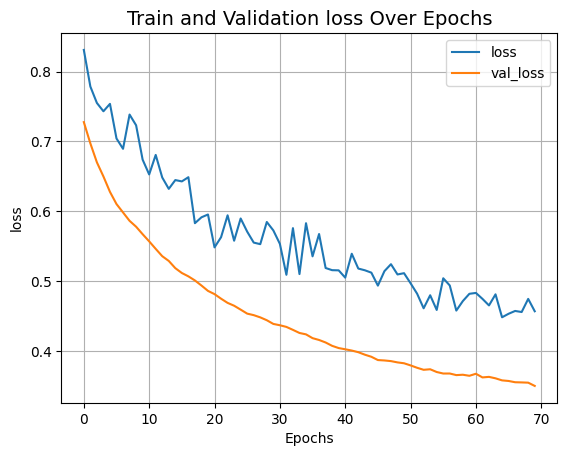

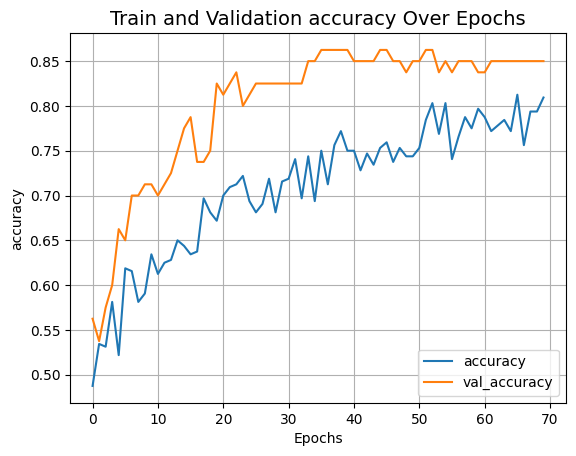

In [76]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("accuracy")

In [ ]:
model_path = '/content/drive/MyDrive/Fall_vs_Sleep_ViTmodel.keras'
model.save(model_path)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


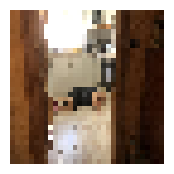

Actual class: Fall | Predicted class: Fall
Probability of being 'Sleep': 7.98%
Prediction: Correct
-----------------------------------------------------


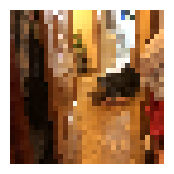

Actual class: Fall | Predicted class: Fall
Probability of being 'Sleep': 18.37%
Prediction: Correct
-----------------------------------------------------


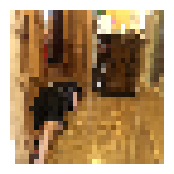

Actual class: Fall | Predicted class: Fall
Probability of being 'Sleep': 19.94%
Prediction: Correct
-----------------------------------------------------


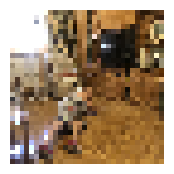

Actual class: Fall | Predicted class: Fall
Probability of being 'Sleep': 23.29%
Prediction: Correct
-----------------------------------------------------


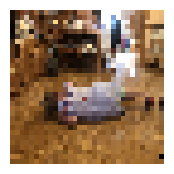

Actual class: Fall | Predicted class: Fall
Probability of being 'Sleep': 22.69%
Prediction: Correct
-----------------------------------------------------


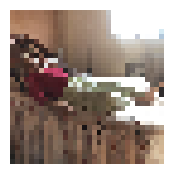

Actual class: Fall | Predicted class: Fall
Probability of being 'Sleep': 17.97%
Prediction: Correct
-----------------------------------------------------


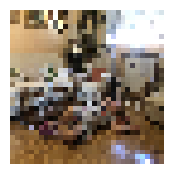

Actual class: Fall | Predicted class: Fall
Probability of being 'Sleep': 12.10%
Prediction: Correct
-----------------------------------------------------


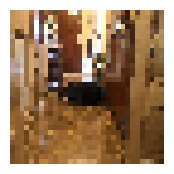

Actual class: Fall | Predicted class: Fall
Probability of being 'Sleep': 11.12%
Prediction: Correct
-----------------------------------------------------


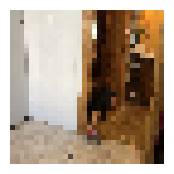

Actual class: Fall | Predicted class: Fall
Probability of being 'Sleep': 31.23%
Prediction: Correct
-----------------------------------------------------


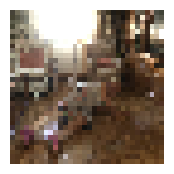

Actual class: Fall | Predicted class: Fall
Probability of being 'Sleep': 11.75%
Prediction: Correct
-----------------------------------------------------


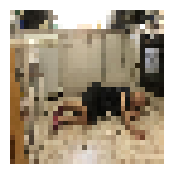

Actual class: Fall | Predicted class: Fall
Probability of being 'Sleep': 9.17%
Prediction: Correct
-----------------------------------------------------


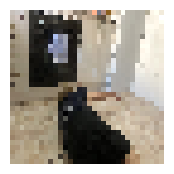

Actual class: Fall | Predicted class: Fall
Probability of being 'Sleep': 30.65%
Prediction: Correct
-----------------------------------------------------


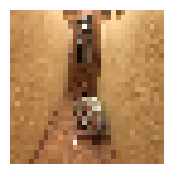

Actual class: Fall | Predicted class: Fall
Probability of being 'Sleep': 13.37%
Prediction: Correct
-----------------------------------------------------


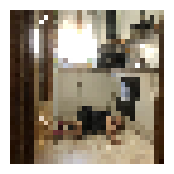

Actual class: Fall | Predicted class: Fall
Probability of being 'Sleep': 11.58%
Prediction: Correct
-----------------------------------------------------


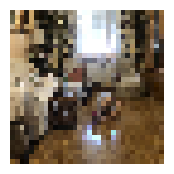

Actual class: Fall | Predicted class: Fall
Probability of being 'Sleep': 8.26%
Prediction: Correct
-----------------------------------------------------


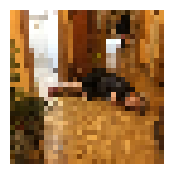

Actual class: Fall | Predicted class: Fall
Probability of being 'Sleep': 17.02%
Prediction: Correct
-----------------------------------------------------


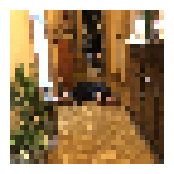

Actual class: Fall | Predicted class: Fall
Probability of being 'Sleep': 13.75%
Prediction: Correct
-----------------------------------------------------


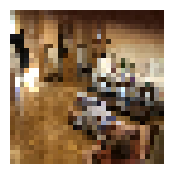

Actual class: Fall | Predicted class: Fall
Probability of being 'Sleep': 16.39%
Prediction: Correct
-----------------------------------------------------


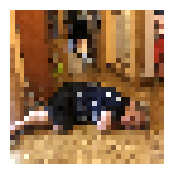

Actual class: Fall | Predicted class: Fall
Probability of being 'Sleep': 14.58%
Prediction: Correct
-----------------------------------------------------


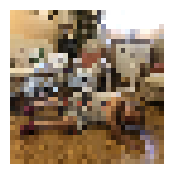

Actual class: Fall | Predicted class: Fall
Probability of being 'Sleep': 12.82%
Prediction: Correct
-----------------------------------------------------


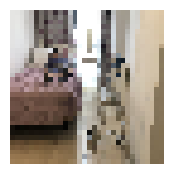

Actual class: Sleep | Predicted class: Fall
Probability of being 'Sleep': 4.34%
Prediction: Incorrect
-----------------------------------------------------


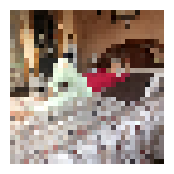

Actual class: Sleep | Predicted class: Sleep
Probability of being 'Sleep': 51.60%
Prediction: Correct
-----------------------------------------------------


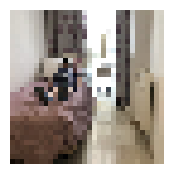

Actual class: Sleep | Predicted class: Fall
Probability of being 'Sleep': 10.01%
Prediction: Incorrect
-----------------------------------------------------


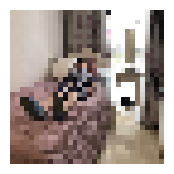

Actual class: Sleep | Predicted class: Fall
Probability of being 'Sleep': 20.26%
Prediction: Incorrect
-----------------------------------------------------


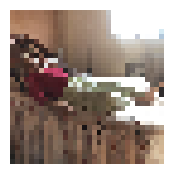

Actual class: Sleep | Predicted class: Fall
Probability of being 'Sleep': 17.97%
Prediction: Incorrect
-----------------------------------------------------


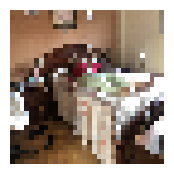

Actual class: Sleep | Predicted class: Fall
Probability of being 'Sleep': 13.59%
Prediction: Incorrect
-----------------------------------------------------


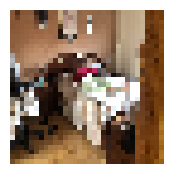

Actual class: Sleep | Predicted class: Fall
Probability of being 'Sleep': 8.01%
Prediction: Incorrect
-----------------------------------------------------


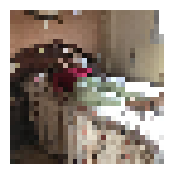

Actual class: Sleep | Predicted class: Fall
Probability of being 'Sleep': 14.72%
Prediction: Incorrect
-----------------------------------------------------


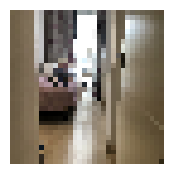

Actual class: Sleep | Predicted class: Fall
Probability of being 'Sleep': 3.08%
Prediction: Incorrect
-----------------------------------------------------


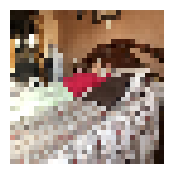

Actual class: Sleep | Predicted class: Sleep
Probability of being 'Sleep': 52.84%
Prediction: Correct
-----------------------------------------------------


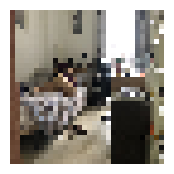

Actual class: Sleep | Predicted class: Fall
Probability of being 'Sleep': 8.12%
Prediction: Incorrect
-----------------------------------------------------


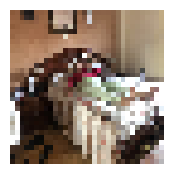

Actual class: Sleep | Predicted class: Fall
Probability of being 'Sleep': 12.54%
Prediction: Incorrect
-----------------------------------------------------


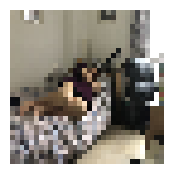

Actual class: Sleep | Predicted class: Fall
Probability of being 'Sleep': 20.18%
Prediction: Incorrect
-----------------------------------------------------


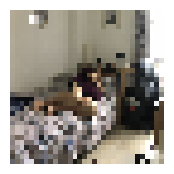

Actual class: Sleep | Predicted class: Fall
Probability of being 'Sleep': 20.21%
Prediction: Incorrect
-----------------------------------------------------


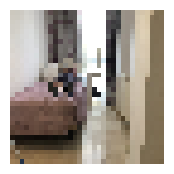

Actual class: Sleep | Predicted class: Fall
Probability of being 'Sleep': 5.29%
Prediction: Incorrect
-----------------------------------------------------


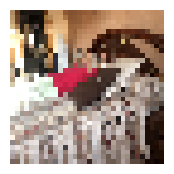

Actual class: Sleep | Predicted class: Fall
Probability of being 'Sleep': 36.90%
Prediction: Incorrect
-----------------------------------------------------


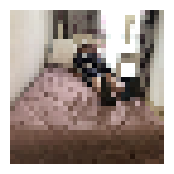

Actual class: Sleep | Predicted class: Fall
Probability of being 'Sleep': 11.59%
Prediction: Incorrect
-----------------------------------------------------


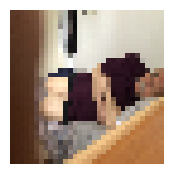

Actual class: Sleep | Predicted class: Fall
Probability of being 'Sleep': 19.51%
Prediction: Incorrect
-----------------------------------------------------


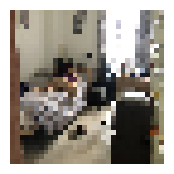

Actual class: Sleep | Predicted class: Fall
Probability of being 'Sleep': 10.41%
Prediction: Incorrect
-----------------------------------------------------


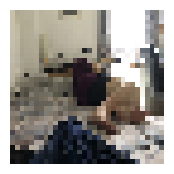

Actual class: Sleep | Predicted class: Fall
Probability of being 'Sleep': 12.14%
Prediction: Incorrect
-----------------------------------------------------
Total accuracy: 55.00%


In [77]:
# x_test 데이터셋에 대한 예측 수행
predictions = model.predict(x_test)
class_names = ['Fall', 'Sleep']
correct_predictions = 0
total_predictions = len(x_test)

for i in range(len(x_test)):
    # sigmoid 확률 값으로 "Sleep" 클래스 예측
    sleep_probability = predictions[i][0]
    predicted_class_index = 1 if sleep_probability > 0.5 else 0

    # 실제 클래스와 비교
    actual_class = "Sleep" if y_test[i] == 1 else "Fall"
    predicted_class = class_names[predicted_class_index]
    is_correct = "Correct" if predicted_class == actual_class else "Incorrect"
    if(is_correct == "Correct"):
        correct_predictions += 1

    # 정확도 계산
    total_accuracy = correct_predictions / total_predictions * 100

    # 이미지 시각화
    plt.figure(figsize=(2,2))
    plt.imshow(x_test[i].astype("uint8"))
    plt.axis('off')
    plt.show()

    # 예측 결과 및 확률 출력
    print(f"Actual class: {actual_class} | Predicted class: {predicted_class}")
    print(f"Probability of being 'Sleep': {sleep_probability * 100:.2f}%")
    print(f"Prediction: {is_correct}")
    print("-----------------------------------------------------")

print(f"Total accuracy: {total_accuracy:.2f}%")


In [78]:
# For Softmax activation
# predictions = model.predict(x_test)
# class_names = ['Fall', 'Sleep']
# correct_predictions = 0
# total_predictions = len(x_test)
# # 결과 출력
# # 결과 및 예측 성공 여부 출력
# for i in range(len(x_test)):
#     # 예측 확률 계산
#     fall_probability = predictions[i][0]
#     sleep_probability = 1 - fall_probability if len(predictions[i]) == 1 else predictions[i][1]

#     # 예측된 클래스 인덱스
#     predicted_class_index = np.argmax(predictions[i])

#     # 실제 클래스와 비교
#     actual_class = "Sleep" if y_test[i] == 1 else "Fall"
#     predicted_class = class_names[predicted_class_index]
#     is_correct = "Correct" if predicted_class == actual_class else "Incorrect"
#     if(is_correct == "Correct"):
#         correct_predictions += 1

#     # 정확도 계산
#     total_accuracy = correct_predictions / total_predictions * 100

#     # 이미지 시각화
#     plt.figure(figsize=(2,2))
#     plt.imshow(x_test[i].astype("uint8"))
#     plt.axis('off')
#     plt.show()

#     # 예측 결과 및 확률 출력
#     print(f"Actual class: {actual_class} | Predicted class: {predicted_class}")
#     print(f"Probability of being 'Fall': {fall_probability * 100:.2f}%")
#     print(f"Probability of being 'Sleep': {sleep_probability * 100:.2f}%")
#     print(f"Prediction: {is_correct}")
#     print("-----------------------------------------------------")
# print(f"Total accuracy: {total_accuracy:.2f}%")